In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

# from google.colab import drive
import glob
import pandas as pd
import keras
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class GRU:
    def __init__(self,epochs=50,learning_rate=0.01,isbatchNormailization=True,droprate=0.5,datapath="",preprocess="StandardScaler",layers=4,cells=16):
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.isbatchNormailization=isbatchNormailization
        self.droprate=droprate
        self.datapath=datapath
        self.preprocess=preprocess
        self.layers=layers
        self.cells=cells
    def load_file(self,file_path):
        l=[]
        with open(file_path, 'r') as f:
            data = []
            for line in f:
                if '#' in line:
                    continue  # Skip comment lines
                line_data = line.strip().split(',')[1:]  
                l.append(line_data)
                numeric_data = [float(x) for x in line_data if x.strip() and x.strip() != '#'] 
                data.append(numeric_data)
    
        if data!=[]:
            data = np.array(data)
            train_x = data[:, :-1]  
            train_y = data[:, -1][0]   
            return train_x, train_y
        return 0,0
 

# Function to load data from all files in a directory
    def load_data_from_directory(self,directory):
        file_paths = glob.glob(directory+"/**/*.csv")
        random.shuffle(file_paths)
        train_x_list = []
        train_y_list = []
        for file_path in file_paths:
            train_x, train_y = self.load_file(file_path)
            if isinstance(train_x,int):
                continue
            train_x_list.append(train_x)
            train_y_list.append(train_y)
        return np.array(train_x_list), np.array(train_y_list)
    def fetchData(self,datadir):
        csv_files=glob.glob(datadir+"/**/*.csv")
        combined_csv = pd.concat([pd.read_csv(f, header=None) for f in csv_files], ignore_index=True)
        del combined_csv[combined_csv.columns[0]]
        combined_csv = combined_csv[combined_csv.iloc[:, 3] !='#']
        data=combined_csv.values
        data = data.astype(np.float32)
        return data
    def createModel(self,layers=4,cells=16):
        model = keras.Sequential()
        # model.add(keras.layers.Rescaling(1./255))
        for _ in range(layers):
            model.add(keras.layers.GRU(cells, activation='tanh', return_sequences=True))
            # model.add(keras.layers.Rescaling(1./255))  # Add rescaling after each GRU layer
            if self.droprate>0:
                model.add(keras.layers.Dropout(self.droprate))
                # model.add(keras.layers.Dropout(0.5))
            if self.isbatchNormailization:
                model.add(keras.layers.BatchNormalization())
        model.add(Flatten())
        model.add(keras.layers.Dense(1))
        return model
    def saveModel(self,model):
        model.save("GRU_Model.h5")
    
    def plotGraphs(self,history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(self.epochs)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
    def getLossAndAccuracy(self,X_test,y_test,model):
        loss, acc = model.evaluate(X_test, y_test)
        print("Test Loss:", loss)
        print("Test Accuracy:", acc)
    def getpreprocess(self, X_train, X_test):
        if self.preprocess == 'StandardScaler':
            scaler = StandardScaler()
        elif self.preprocess == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif self.preprocess == 'RobustScaler':
            scaler = RobustScaler()
        elif self.preprocess == 'Normalizer':
            scaler = Normalizer()
        
        X_train_processed = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test_processed = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
        return X_train_processed, X_test_processed

        
    def train(self):
        
        X_train,y_train=self.load_data_from_directory(self.datapath)
        y_train=y_train.reshape(-1, 1)
        X_train, X_test, y_train,y_test  = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
        X_train, X_test=self.getpreprocess(X_train,X_test)

        model=self.createModel(layers=self.layers,cells=self.cells)
        model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), loss=keras.losses.Huber(), metrics=['accuracy'])
        history=model.fit(X_train, y_train, epochs=100, batch_size=64,
                        #   callbacks=[early_stopping],
                          validation_data=(X_test,y_test))
        
        
        self.saveModel(model)
        self.plotGraphs(history=history)
        self.getLossAndAccuracy(X_test,y_test,model)
        # output_shape = model.output_shape
        # print("Output shape:", output_shape)
        
        
                
        

    

Epoch 1/100
8/8 [==============================] - 4s 133ms/step - loss: 0.7716 - accuracy: 0.5700 - val_loss: 0.1632 - val_accuracy: 0.6316
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.6570 - accuracy: 0.5720 - val_loss: 0.1506 - val_accuracy: 0.6316
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.5667 - accuracy: 0.5464 - val_loss: 0.1482 - val_accuracy: 0.6316
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.5351 - accuracy: 0.5602 - val_loss: 0.1366 - val_accuracy: 0.6316
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.6052 - accuracy: 0.5306 - val_loss: 0.1281 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.5338 - accuracy: 0.5720 - val_loss: 0.1265 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.4399 - accuracy: 0.5700 - val_loss: 0.1237 - val_accuracy: 0.6316
Epoch 8/100
8/8 [==

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


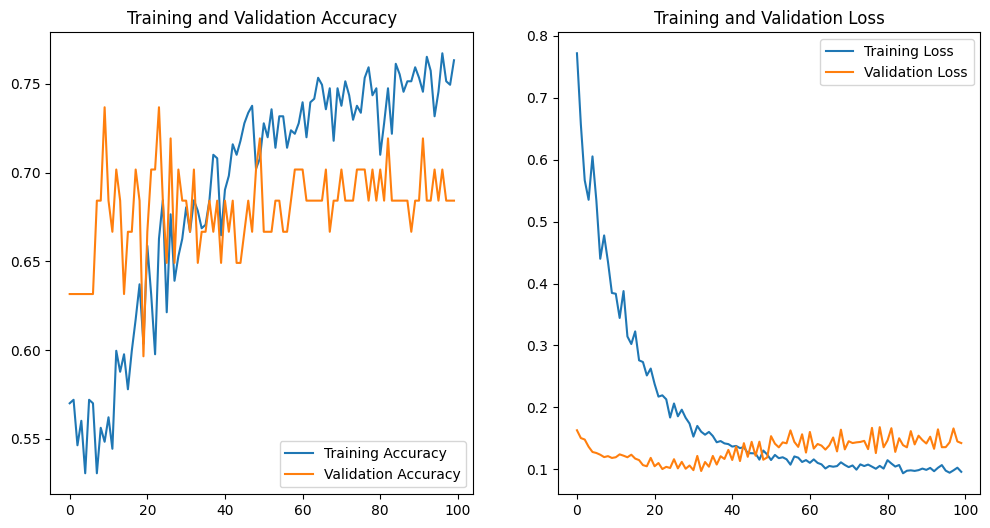

2/2 [==============================] - 0s 5ms/step - loss: 0.1425 - accuracy: 0.6842
Test Loss: 0.14251835644245148
Test Accuracy: 0.6842105388641357


In [3]:
#with 3 layers and 32 cells (Architecture-1)
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"StandardScaler",layers=3,cells=32)
s.train()

Epoch 1/100
8/8 [==============================] - 9s 254ms/step - loss: 0.7079 - accuracy: 0.5128 - val_loss: 0.1674 - val_accuracy: 0.6667
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 0.6684 - accuracy: 0.5266 - val_loss: 0.1487 - val_accuracy: 0.6667
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 0.6054 - accuracy: 0.5168 - val_loss: 0.1362 - val_accuracy: 0.6667
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 0.5667 - accuracy: 0.5562 - val_loss: 0.1314 - val_accuracy: 0.6667
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 0.5482 - accuracy: 0.5602 - val_loss: 0.1310 - val_accuracy: 0.6667
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 0.4772 - accuracy: 0.5759 - val_loss: 0.1262 - val_accuracy: 0.6667
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 0.4700 - accuracy: 0.5523 - val_loss: 0.1208 - val_accuracy: 0.6667
Epoch 8/100
8/8 [==

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


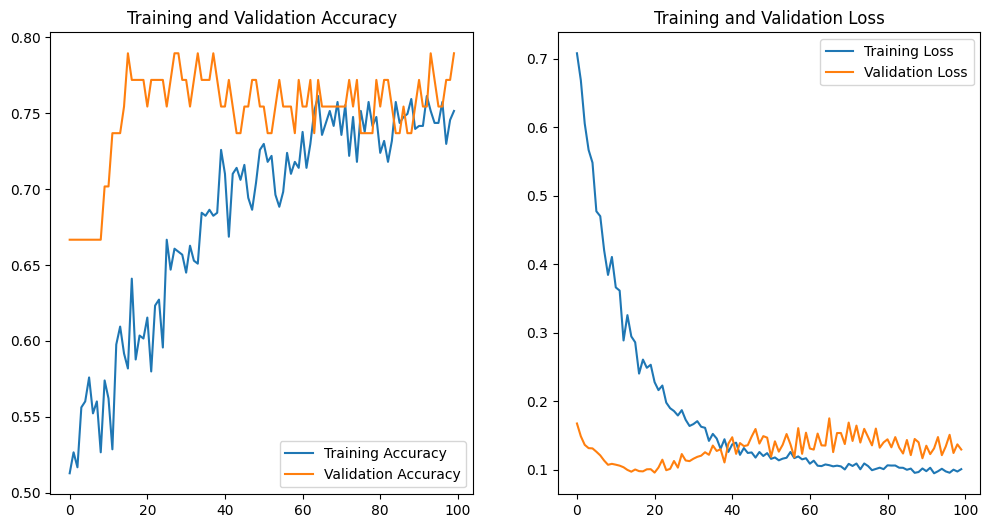

2/2 [==============================] - 0s 9ms/step - loss: 0.1294 - accuracy: 0.7895
Test Loss: 0.12935581803321838
Test Accuracy: 0.7894737124443054


In [85]:
#with 4 layers and 16 cells (Architecture-2)
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"RobustScaler",layers=4,cells=16)
s.train()

Epoch 1/100
8/8 [==============================] - 5s 183ms/step - loss: 0.7366 - accuracy: 0.4517 - val_loss: 0.2126 - val_accuracy: 0.6140
Epoch 2/100
8/8 [==============================] - 0s 40ms/step - loss: 0.6912 - accuracy: 0.4655 - val_loss: 0.2031 - val_accuracy: 0.6140
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 0.6373 - accuracy: 0.4714 - val_loss: 0.2167 - val_accuracy: 0.6140
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 0.5789 - accuracy: 0.5069 - val_loss: 0.2228 - val_accuracy: 0.6140
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 0.6233 - accuracy: 0.4477 - val_loss: 0.1919 - val_accuracy: 0.6140
Epoch 6/100
8/8 [==============================] - 0s 58ms/step - loss: 0.5448 - accuracy: 0.4576 - val_loss: 0.2157 - val_accuracy: 0.6140
Epoch 7/100
8/8 [==============================] - 0s 41ms/step - loss: 0.5251 - accuracy: 0.5030 - val_loss: 0.1968 - val_accuracy: 0.6140
Epoch 8/100
8/8 [==

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


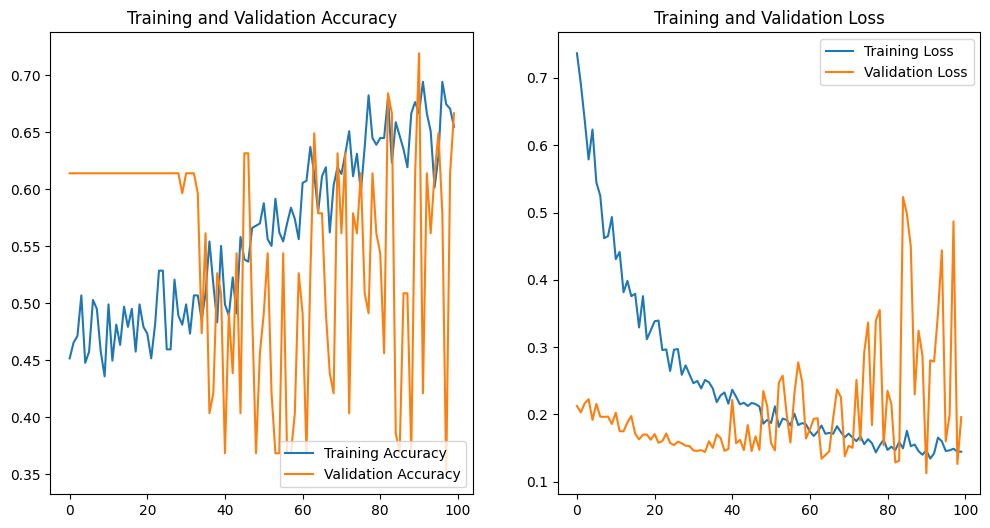

2/2 [==============================] - 0s 7ms/step - loss: 0.1961 - accuracy: 0.6667
Test Loss: 0.19614849984645844
Test Accuracy: 0.6666666865348816


In [86]:
#with 2 layers and 64 cells (Architecture-3)
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"MinMaxScaler",layers=2,cells=64)
s.train()

Epoch 1/100
8/8 [==============================] - 12s 212ms/step - loss: 0.8623 - accuracy: 0.4398 - val_loss: 0.1929 - val_accuracy: 0.6316
Epoch 2/100
8/8 [==============================] - 1s 91ms/step - loss: 0.7097 - accuracy: 0.4517 - val_loss: 0.2072 - val_accuracy: 0.6316
Epoch 3/100
8/8 [==============================] - 1s 87ms/step - loss: 0.7146 - accuracy: 0.4931 - val_loss: 0.1861 - val_accuracy: 0.6316
Epoch 4/100
8/8 [==============================] - 1s 88ms/step - loss: 0.6975 - accuracy: 0.4714 - val_loss: 0.2081 - val_accuracy: 0.6316
Epoch 5/100
8/8 [==============================] - 1s 86ms/step - loss: 0.5956 - accuracy: 0.4497 - val_loss: 0.2046 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 1s 92ms/step - loss: 0.5799 - accuracy: 0.4753 - val_loss: 0.1858 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 1s 97ms/step - loss: 0.5675 - accuracy: 0.5049 - val_loss: 0.1771 - val_accuracy: 0.6316
Epoch 8/100
8/8 [=

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


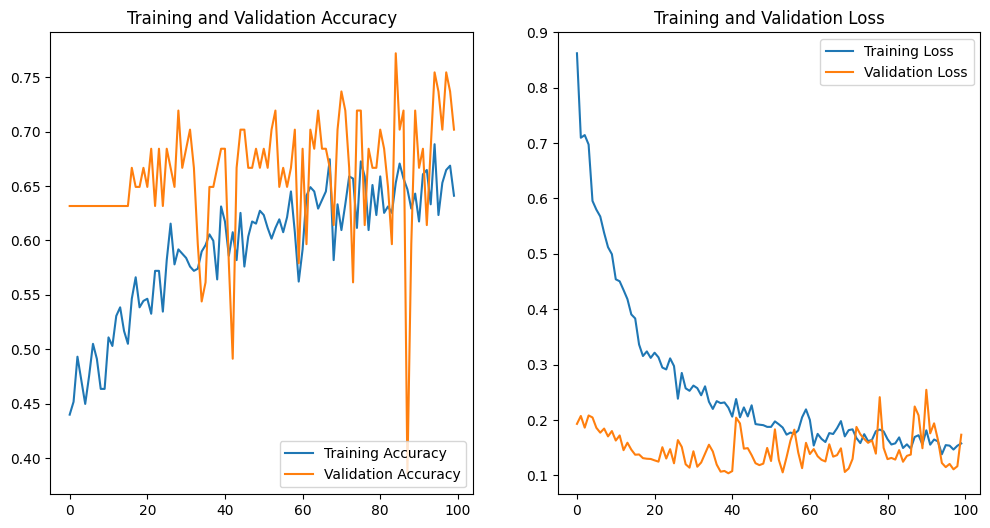

2/2 [==============================] - 0s 19ms/step - loss: 0.1733 - accuracy: 0.7018
Test Loss: 0.17332331836223602
Test Accuracy: 0.7017543911933899


In [87]:
#with 3 layers and 128 cells (Architecture-4)
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"Normalizer",layers=3,cells=128)
s.train()

Epoch 1/100
8/8 [==============================] - 5s 122ms/step - loss: 0.8083 - accuracy: 0.4990 - val_loss: 0.3052 - val_accuracy: 0.5439
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.6664 - accuracy: 0.4753 - val_loss: 0.2797 - val_accuracy: 0.5439
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.6256 - accuracy: 0.5444 - val_loss: 0.2613 - val_accuracy: 0.5439
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.6307 - accuracy: 0.5424 - val_loss: 0.2521 - val_accuracy: 0.5439
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.5553 - accuracy: 0.5365 - val_loss: 0.2462 - val_accuracy: 0.5439
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.5224 - accuracy: 0.5542 - val_loss: 0.2408 - val_accuracy: 0.5439
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.4577 - accuracy: 0.5523 - val_loss: 0.2335 - val_accuracy: 0.5439
Epoch 8/100
8/8 [==

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


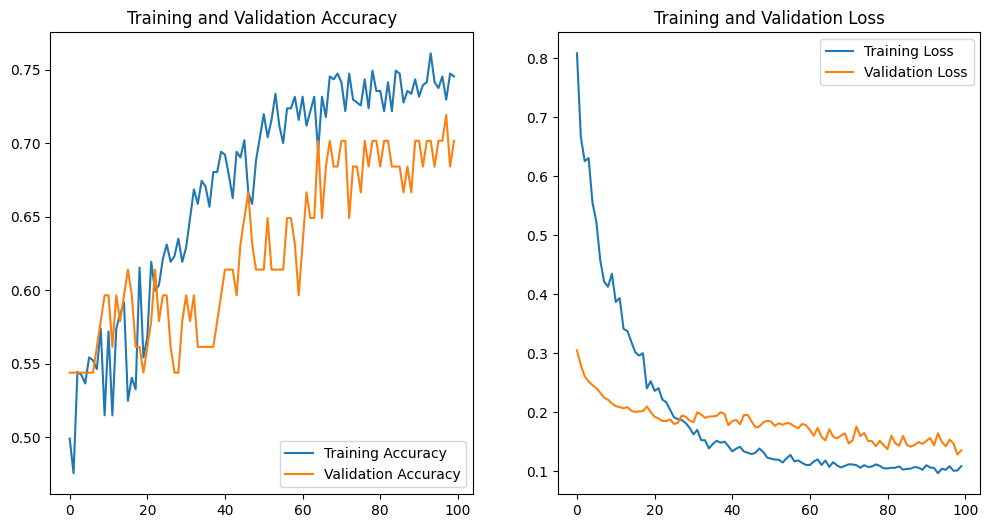

2/2 [==============================] - 0s 6ms/step - loss: 0.1355 - accuracy: 0.7018
Test Loss: 0.13552923500537872
Test Accuracy: 0.7017543911933899


In [79]:
#with standardscaler perprocess
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"StandardScaler",layers=4,cells=16)
s.train()

Epoch 1/100
8/8 [==============================] - 8s 209ms/step - loss: 0.7990 - accuracy: 0.5542 - val_loss: 0.1813 - val_accuracy: 0.5965
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 0.6828 - accuracy: 0.5148 - val_loss: 0.1630 - val_accuracy: 0.5965
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 0.6511 - accuracy: 0.5759 - val_loss: 0.1507 - val_accuracy: 0.5965
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.6025 - accuracy: 0.5187 - val_loss: 0.1405 - val_accuracy: 0.5965
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 0.5412 - accuracy: 0.5404 - val_loss: 0.1330 - val_accuracy: 0.5965
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 0.5222 - accuracy: 0.5266 - val_loss: 0.1264 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 0.4748 - accuracy: 0.5385 - val_loss: 0.1212 - val_accuracy: 0.7018
Epoch 8/100
8/8 [==

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


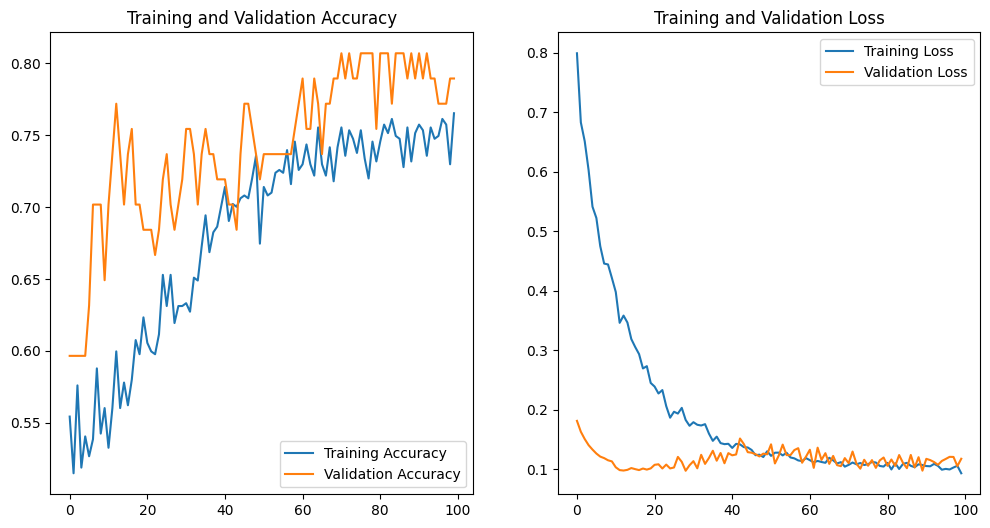

2/2 [==============================] - 0s 6ms/step - loss: 0.1176 - accuracy: 0.7895
Test Loss: 0.11759095638990402
Test Accuracy: 0.7894737124443054


In [80]:
#with RobustScaler preprocess
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"RobustScaler",layers=4,cells=16)
s.train()

Epoch 1/100
8/8 [==============================] - 15s 200ms/step - loss: 0.8082 - accuracy: 0.5069 - val_loss: 0.2154 - val_accuracy: 0.5789
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 0.7045 - accuracy: 0.5187 - val_loss: 0.1880 - val_accuracy: 0.5789
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 0.5787 - accuracy: 0.5365 - val_loss: 0.1849 - val_accuracy: 0.5789
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 0.5740 - accuracy: 0.4556 - val_loss: 0.1970 - val_accuracy: 0.5789
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 0.5534 - accuracy: 0.4714 - val_loss: 0.1941 - val_accuracy: 0.5789
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.5787 - accuracy: 0.4379 - val_loss: 0.1899 - val_accuracy: 0.5789
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 0.5135 - accuracy: 0.4536 - val_loss: 0.2006 - val_accuracy: 0.5789
Epoch 8/100
8/8 [=

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


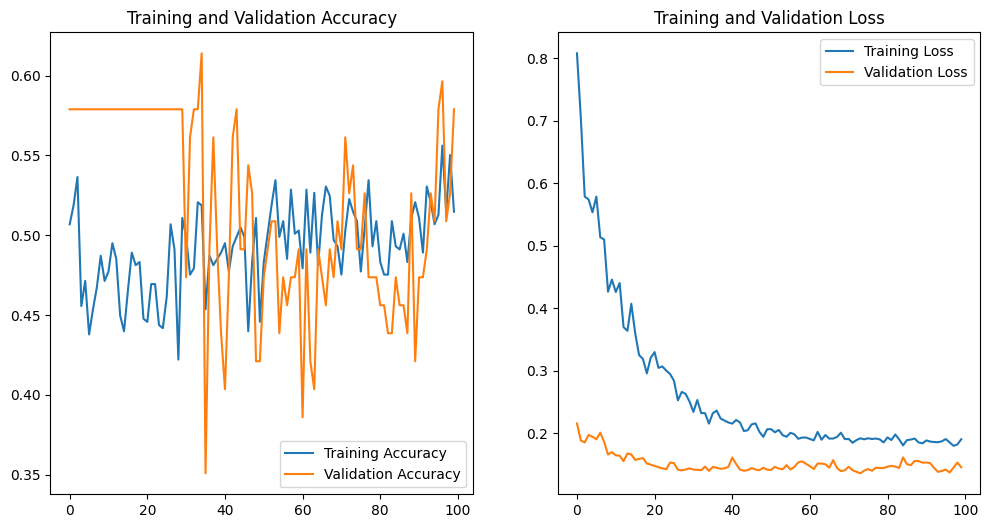

2/2 [==============================] - 0s 15ms/step - loss: 0.1452 - accuracy: 0.5789
Test Loss: 0.14519378542900085
Test Accuracy: 0.5789473652839661


In [82]:
#with minMaxScaler preprocess
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"MinMaxScaler",layers=4,cells=16)
s.train()

Epoch 1/100
8/8 [==============================] - 8s 199ms/step - loss: 0.8648 - accuracy: 0.4753 - val_loss: 0.2279 - val_accuracy: 0.5439
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 0.7243 - accuracy: 0.4951 - val_loss: 0.2088 - val_accuracy: 0.5439
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 0.5891 - accuracy: 0.5345 - val_loss: 0.2052 - val_accuracy: 0.5439
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.6090 - accuracy: 0.4931 - val_loss: 0.2063 - val_accuracy: 0.5439
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 0.5809 - accuracy: 0.4694 - val_loss: 0.2127 - val_accuracy: 0.5439
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.5820 - accuracy: 0.4832 - val_loss: 0.2118 - val_accuracy: 0.5439
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 0.5082 - accuracy: 0.4872 - val_loss: 0.2022 - val_accuracy: 0.5439
Epoch 8/100
8/8 [==

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


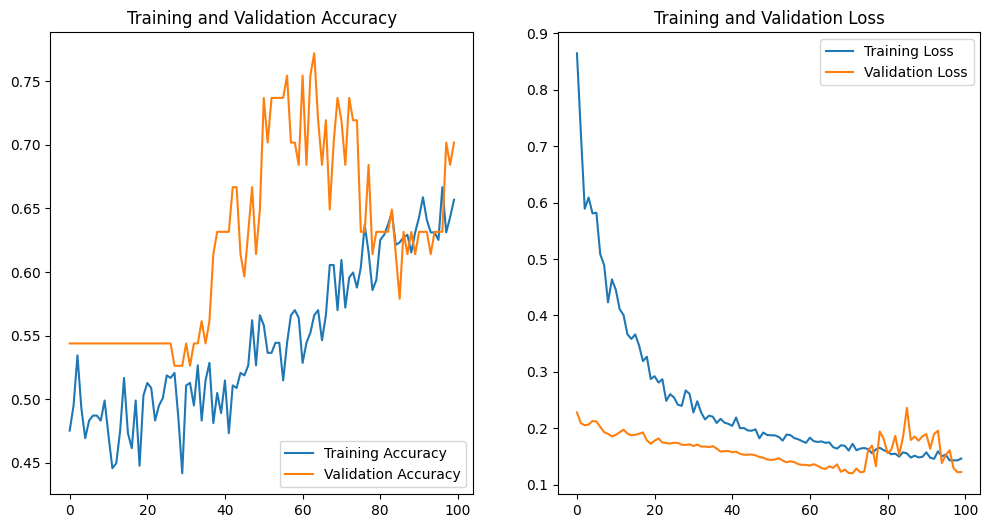

2/2 [==============================] - 0s 6ms/step - loss: 0.1222 - accuracy: 0.7018
Test Loss: 0.12216655164957047
Test Accuracy: 0.7017543911933899


In [83]:
#with Normalisation preprocess
datadir='/Users/yeshwanth/Documents/DL/project-2/part-1/training-validation'
s=GRU(100,0.01,True,0.5,datadir,"Normalizer",layers=4,cells=16)
s.train()